# Assignment 3

### Title : Covid 19 modelling
Name : Adarsh Shah
SR no : 19473

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,log10
import datetime

# SEIRV Model

In [2]:
def SEIRV(b,t):
    dS[t] = round(-b*S[t]*I[t]/N-e*dV(t)+dW(t))
    dE[t] = round(b*S[t]*I[t]/N-a*E[t])
    dI[t] = round(a*E[t]-g*I[t])
    dR[t] = round(g*I[t]-dW(t)+e*dV(t))    

### Global Constants

In [3]:
a = 1/5.8
g = 1/5
e = 0.66
N = 70000000

### Reading Data

In [4]:
data = pd.read_csv('COVID19_data.csv')
# Confirmed Cases
C = np.array(data[(data['Date']>='2021-03-09') & (data['Date']<='2021-09-20')]['Confirmed'])
# Tested Cases
T = np.array(data[(data['Date']>='2021-03-09') & (data['Date']<='2021-09-20')]['Tested'])
# Vaccinated
V = np.array(data[(data['Date']>='2021-03-14') & (data['Date']<='2021-04-26')]['First Dose Administered'])

In [5]:
#Constraints
R0_con = (0.156*N,0.36*N)
CIR0_con = (12,30)
#Taken 7 days extra before to adjust seven week average calculation
days = 37
#Time Series to store intermediate result
S = np.zeros(days)
E = np.zeros(days)
I = np.zeros(days)
R = np.zeros(days)
dS= np.zeros(days)
dE= np.zeros(days)
dI= np.zeros(days)
dR= np.zeros(days)

#Number of Vaccinations per day
# 2 lakh vaccinations after 2021-04-21
def dV(t):
    try:
        return V[t+1]-V[t]
    except IndexError:
        return 200000

#Susceptible generating due to Immunity waining.
def dW(t):
    if t>=180:
        return dR[t-30] + e*dV(t-180)
    elif t<=37:
        return R[0]/30
    else :
        return dR[t-30]

#Cases to infection ratio
def CIR(t,CIR0):
    T0 = np.mean(T[0:7])
    Tt = np.mean(T[t:t+7])
    return CIR0*T0/max(1,Tt)

#Loss function
def loss(x):
    b,S[0],E[0],I[0],R[0],CIR0=x[0],x[1],x[2],x[3],x[4],x[5]
    #Safety operation to ensure conservation of population
    S[0]=N-E[0]-I[0]-R[0]
    for t in range(days-1):
        SEIRV(b,t)
        S[t+1]=min(N,max(0,S[t]+dS[t]))
        E[t+1]=min(N,max(0,E[t]+dE[t]))
        I[t+1]=min(N,max(0,I[t]+dI[t]))
        R[t+1]=min(N,max(0,R[t]+dR[t]))
    i = np.zeros(days-1)
    for t in range(days-1):
        i[t]=I[t+1]/CIR(t+1,CIR0)-I[t]/CIR(t,CIR0)
    #days is 37 that's why 37-8
    #X contains average confirmed cases from CSV
    #Y contains average confirmed cases obtained after simulation
    #days = 37 thaat's why days-8
    X,Y=np.zeros(days-8),np.zeros(days-8)
    for t in range(days-8):
        X[t] = log10((C[t+7]-C[t])/7)
        try :
            Y[t] = log10(np.mean(i[t:t+7]))
        except ValueError:
            Y[t] = 0
    s = np.sum(np.square(X-Y))/42
    return s

#Utility function to plot result after minimization
def plot(x):
    b,S[0],E[0],I[0],R[0],CIR0=x[0],x[1],x[2],x[3],x[4],x[5]
    S[0]=N-E[0]-I[0]-R[0]
    for t in range(days-1):
        SEIRV(b,t)
        S[t+1]=S[t]+dS[t]
        E[t+1]=E[t]+dE[t]
        I[t+1]=I[t]+dI[t]
        R[t+1]=R[t]+dR[t]
    i = np.zeros(days)
    
    for t in range(days-1):
        i[t]=I[t+1]/CIR(t+1,CIR0)-I[t]/CIR(t,CIR0)
    X,Y=np.zeros(days-8),np.zeros(days-8)
    for t in range(days-8):
        X[t] = log10((C[t+7]-C[t])/7)
        Y[t] = log10(max(1,np.mean(i[t:t+7])))
    plt.subplot(121)
    plt.xlabel('days')
    plt.ylabel('log(cases)')
    plt.title('From CSV')
    plt.scatter(x=range(len(X)),y=X)
    plt.subplot(122)
    plt.xlabel('days')
    plt.ylabel('log(cases)')
    plt.title(f'Predicted Loss={loss(x):.4f}')
    plt.scatter(x=range(len(Y)),y=Y)
    plt.show()
    plt.clf()

### Gradient Descent

In [6]:
#Calculates the gradient of [beta,S0,E0,I0,R0,CIR0] after pertubation as mentioned in assignment
def gradient(x):
    grad = np.zeros(6)
    y = x.copy()
    mn = loss(x)
    res = np.zeros(6)
    for j1 in [-0.01,0.01]:
        y[0]=x[0]+j1
        for i1 in [-1,1]:
            y[1]=x[1]+i1
            for i2 in [-1,1]:
                y[2]=x[2]+i2
                for i3 in [-1,1]:
                    y[3]=x[3]+i3
                    for i4 in [-1,1]:
                        if x[4] >= R0_con[0] and x[4] <= R0_con[1]:
                            y[4]=x[4]+i4
                        for j2 in [-0.1,0.1]:
                            if x[5] >= CIR0_con[0] and x[4] <= CIR0_con[1]:
                                y[5]=x[5]+j2 
                            l = loss(y)
                            if l > mn:
                                res = [j1,i1,i2,i3,i4,j2]
                                mn = l
    return res,mn    

#Gradient Descent algo
def minimize(x,iter):
    #To make S = N - E - I - R
    x[1] = N - x[2]-x[3]-x[4]
    _,u = gradient(x)
    i=0
    j=1
    while u>0.01 and i<iter:
        #Projecting constraint on the inputs after every 100 iterations
        #Partial gradient descent. j=1 after 100 iterations.
        if i%100==0:
            b,S,E,I,R,CIR = x
            E,I,R = int(E),int(I),int(R)
            S = N - E - I - R
            x = np.array([b,S,E,I,R,CIR])
            j=1
            u = loss(x)
            print(f'\nloss :{u:.6f}, x:{x[0]:.5f},{int(x[1])},{int(x[2])},{int(x[3])},{int(x[4])},{x[5]:.3f}')   
        dx,u = gradient(x)
        x = x-np.multiply(np.divide(dx,j),u-loss(x))
        j+=1
        i=i+1
        u = loss(x)
        print(".",end='')
        if u<=0.01:
            b,S,E,I,R,CIR = x
            E,I,R = int(E),int(I),int(R)
            S = N - E - I - R
            x = np.array([b,S,E,I,R,CIR])
            u = loss(x)
            print(f'\n loss :{u:.6f}, x:{x[0]:.5f},{int(x[1])},{int(x[2])},{int(x[3])},{int(x[4])},{x[5]:.3f}')
    return x,u

In [7]:
#Obtained the initial estimate after running the algo for a long time.
#Uncomment to run gradient descent. It will take a lot of time.
#xopt,_ = minimize([0.45,0.7*N,0.01*N,0.01*N,0.3*N,23.000],10000)
#print(xopt)
#plot(xopt)

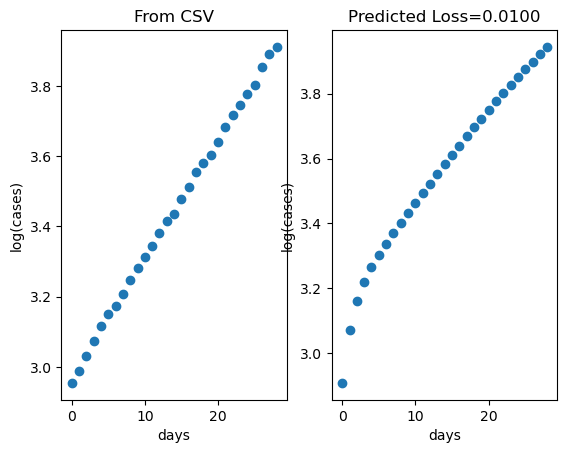

In [8]:
#We get the following after optimization
xopt = [0.44905,47600008,699996,699996,21000000,23.010]
days=37
plot(xopt)

### 3.a Open Loop Controls

/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


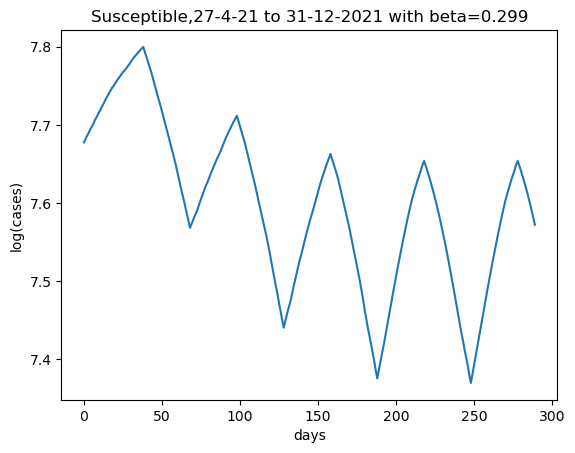

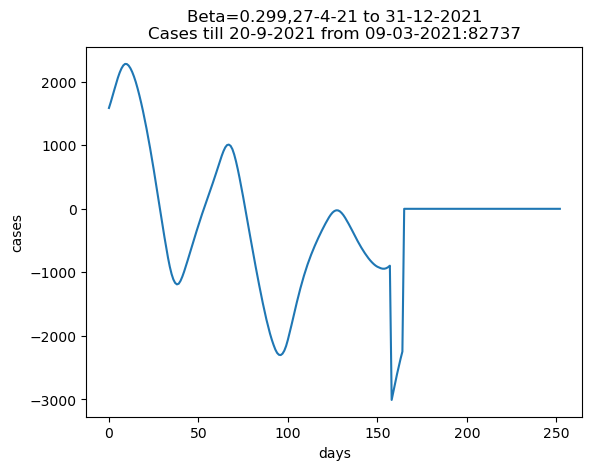

/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


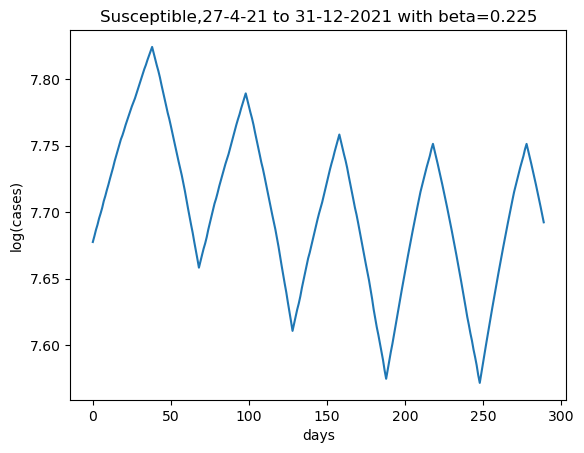

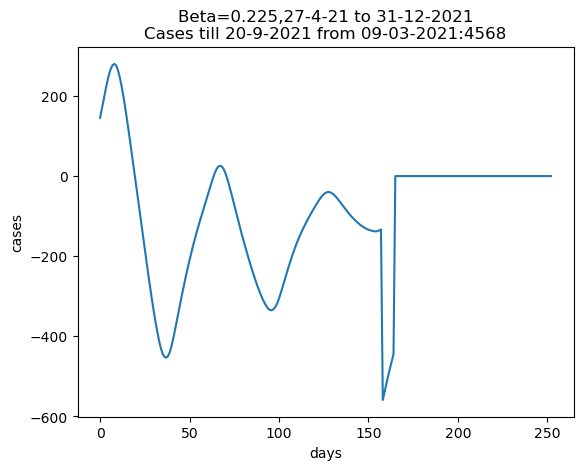

/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


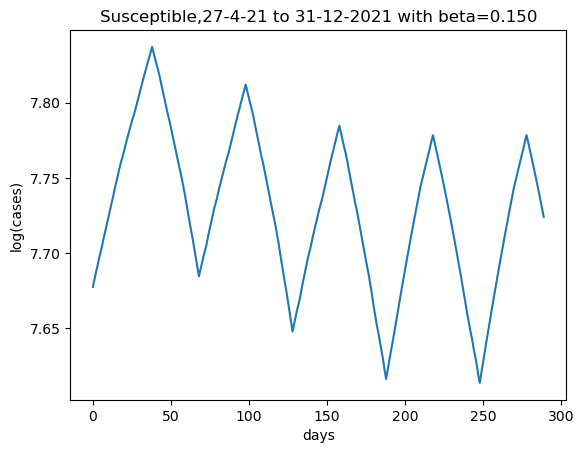

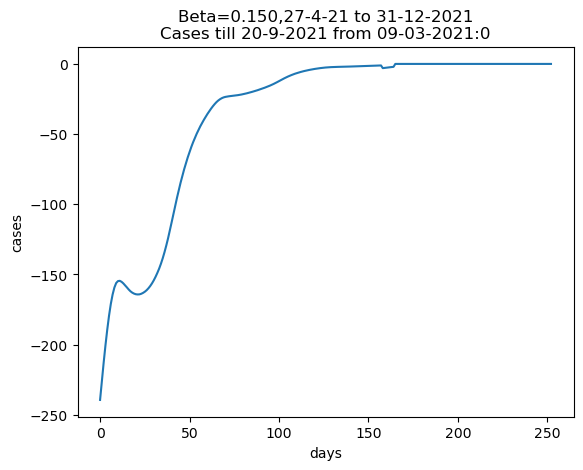

In [18]:
days = (datetime.date(2021,12,31)-datetime.date(2021,3,16)).days
#optimal beta
beta,CIR0 = xopt[0],xopt[5]
#Initializing buffers to store information
S = np.zeros(days)
E = np.zeros(days)
I = np.zeros(days)
R = np.zeros(days)
dS= np.zeros(days)
dE= np.zeros(days)
dI= np.zeros(days)
dR= np.zeros(days)
#Three scenarios in a loop.
for x in [2/3,1/2,1/3]:
    b = beta*x
    #Simulating SEIRV
    S[0],E[0],I[0],R[0] = xopt[1],xopt[2],xopt[3],xopt[4]
    for t in range(days-1):
        SEIRV(b,t)
        S[t+1]=S[t]+dS[t]
        E[t+1]=E[t]+dE[t]
        I[t+1]=I[t]+dI[t]
        R[t+1]=R[t]+dR[t]
    i = np.zeros(days)
    for t in range(days-1):
        i[t]=I[t+1]/CIR(t+1,CIR0)-I[t]/CIR(t,CIR0)
    X,Y=np.zeros(days-7),np.zeros(days-7)
    for t in range(7,days):
        Y[t-7] = np.mean(i[t-7:t])
    #cases till 20th September
    ddays = (datetime.date(2021,9,20)-datetime.date(2021,3,9)).days
    s = 0
    for k in range(ddays):
        if i[k]>0:
            s += i[k]
    #Plotting the evolution of Susceptible
    plt.xlabel('days')
    plt.ylabel('log(cases)')
    plt.title(f'Susceptible,27-4-21 to 31-12-2021 with beta={b:.3f}')
    S_ = np.copy(S)
    for i in range(len(S_)):
        if S_[i]<=1:
            S_[i]=1
    S_ = np.log10(S_)
    plt.plot(S_)
    plt.show()
    plt.clf()
    #Plotting the predicted cases
    plt.xlabel('days')
    plt.ylabel('cases')
    plt.title(f'Beta={b:.3f},27-4-21 to 31-12-2021\nCases till 20-9-2021 from 09-03-2021:{int(s)}')
    plt.plot(Y[30:])
    plt.show()
    plt.clf()

### 3b Closed Loop Control

/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adarshshah/opt/miniconda3/envs/e0_259_da/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


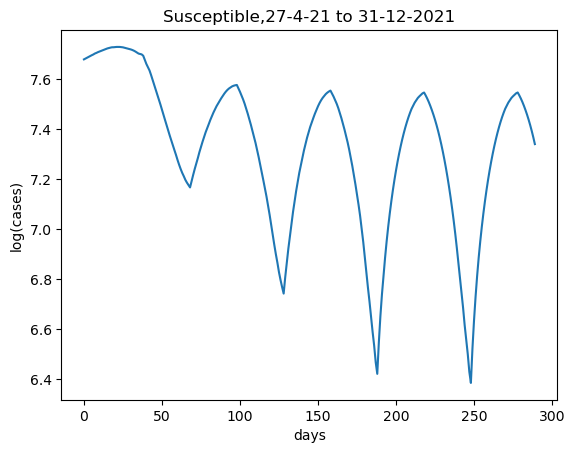

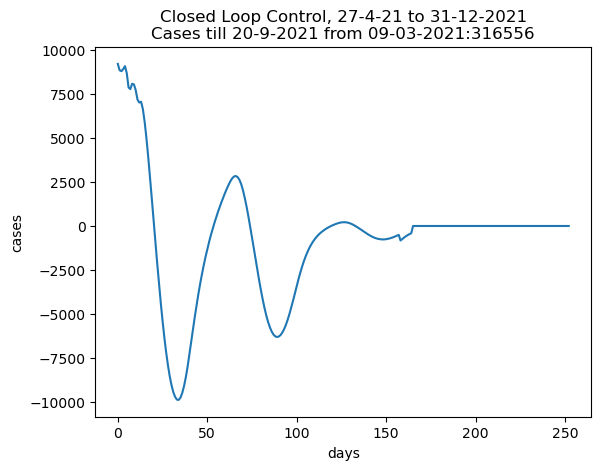

In [17]:
days = (datetime.date(2021,12,31)-datetime.date(2021,3,16)).days
#optimal beta
beta,CIR0 = xopt[0],xopt[5]
S = np.zeros(days)
E = np.zeros(days)
I = np.zeros(days)
R = np.zeros(days)
dS= np.zeros(days)
dE= np.zeros(days)
dI= np.zeros(days)
dR= np.zeros(days)
#Simulating SEIRV
S[0],E[0],I[0],R[0] = xopt[1],xopt[2],xopt[3],xopt[4]
i = np.zeros(days)
for t in range(days-1):
    SEIRV(b,t)
    S[t+1]=S[t]+dS[t]
    E[t+1]=E[t]+dE[t]
    I[t+1]=I[t]+dI[t]
    R[t+1]=R[t]+dR[t]
    i[t]=I[t+1]/CIR(t+1,CIR0)-I[t]/CIR(t,CIR0)
    if i[t] < 10000:
        b = beta
    elif i[t] < 25000:
        b = 2*beta/3
    elif i[t] < 100000:
        b = beta/2
    else:
        b = beta/3
X,Y=np.zeros(days-7),np.zeros(days-7)
for t in range(7,days):
    Y[t-7] = np.mean(i[t-7:t])
#cases till 20th September
ddays = (datetime.date(2021,9,20)-datetime.date(2021,3,9)).days
s = 0
for k in range(ddays):
    if i[k]>0:
        s += i[k]
#Plotting the evolution of Susceptible
plt.xlabel('days')
plt.ylabel('log(cases)')
plt.title(f'Susceptible,27-4-21 to 31-12-2021')
S_ = np.copy(S)
for i in range(len(S_)):
    if S_[i]<=1:
        S_[i]=1
S_ = np.log10(S_)
plt.plot(S_)
plt.show()
plt.clf()
#Plotting the predicted cases
plt.xlabel('days')
plt.ylabel('cases')
plt.title(f'Closed Loop Control, 27-4-21 to 31-12-2021\nCases till 20-9-2021 from 09-03-2021:{int(s)}')
plt.plot(Y[30:])
plt.show()
plt.clf()